## Burgers: One-pfive step Method

In [1]:
import sys
#sys.path.append('/Users/josorior/Documents/UW/research/keql/KEQL/source')
#sys.path.append('/Users/yasaminjalalian/Repos/KEQL/source')
sys.path.append('/home/juanfelipe/Desktop/research/keql/source')

In [2]:
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [3]:
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.kernel_ridge import KernelRidge
from tqdm import tqdm
from parameter_learning import *
from plotlib import *
from models import * 
from kernels import *
from data_loader_Burgers5 import *
from loss import *
from utils import *

import jax.numpy as jnp
from jax import grad, jit
from jax.scipy.optimize import minimize
from jax.config import config; 
config.update("jax_enable_x64", True)

from functools import partial # for jit to make codes faster

(100, 320)


In [4]:
# Import values from 2-step
two_step_dict = np.load('data/two_step_dict.npy', allow_pickle=True)
two_step_dict = two_step_dict.item()

In [5]:
two_step_dict

{'optim_sgm_u': array([1.06175706, 6.40914066, 2.12145157]),
 'optim_nugget_u': array([1.00000000e-08, 4.83293024e-09, 1.00000000e-14]),
 'rkhs_u': [60212845.59795037],
 'optim_sgm_P': 0.14628186644230176,
 'optim_nugget_P': 1e-08,
 'nugget_P': 1e-07,
 'rkhs_P_train': 1.0081583328838113,
 'f_gh_tr_pred': array([-0.02174992, -0.0231847 , -0.02257531, ...,  0.00156083,
         0.00157798,  0.00161245]),
 'rkhs_P_test': 0.3246365905999198}

### Cost function

Create objective function `L`

$$
L(Z_0) = f(X_N)^T \Gamma(S_N,S_N)^{-1} f(X_N) + \lambda \sum_{i=1}^m (Z_{0,i*N:(i+1)*N})^T K(X_N,X_N)^{-1}(Z_{0,i*N:(i+1)*N})
$$
where
$$
Z_0[M] = U[M].
$$

1. Get `f_gh_tr_pred` from two step to be the new `f` in the 1.5 step method.

In [6]:
# First column in Gamma(S_N,S_N)
X = X_gh_tr # (N_gh_tr*m, 2)

# Second column in Gamma(S_N,S_N)
U = U_gh_tr.reshape(N_gh_tr*m,) # (N_gh_tr*m, )

# f(X_N)
#f = f_Test(model,e_test)
f = two_step_dict['f_gh_tr_pred']

In [7]:
# Load values of U predicted from 2-step at te points: originally wrong
U_gh_tr_pred = np.load('data/U_gh_tr_pred.npy')
U_x_gh_tr_pred = np.load('data/U_x_gh_tr_pred.npy')
U_xx_gh_tr_pred = np.load('data/U_xx_gh_tr_pred.npy')
# Build Z_warm
Z_warm = jnp.array(U_gh_tr_pred.T.reshape(N_gh_tr*m,)) 

In [8]:
# # Load values of U predicted from 2-step at te points: originally wrong
# U_te_pred = np.load('data/U_te_pred.npy')
# U_x_te_pred = np.load('data/U_x_te_pred.npy')
# U_xx_te_pred = np.load('data/U_xx_te_pred.npy')
# # Build Z_warm
# Z_warm = jnp.array(U_te_pred.T.reshape(N_te*m,)) 

First iteration RKHS norm of P 

In [9]:
S = jnp.zeros((N_gh_tr*m, 5))

# Split Z
for i in range(m):
    Zi = Z_warm[i*N_gh_tr:(i+1)*N_gh_tr]
    optim_sgm = two_step_dict.get('optim_sgm_u')[i]
    optim_nugget = two_step_dict.get('optim_nugget_u')[i]
    G = K_2D(Gaussian2D, X[:N_gh_tr], X[:N_gh_tr], optim_sgm) 
    alphas = jnp.linalg.solve(G + optim_nugget*jnp.eye(N_gh_tr),Zi)

    Zi_x = jnp.dot(K_dot2D(Gaussian2D, X[:N_gh_tr], X[:N_gh_tr], optim_sgm, 1), alphas)
    Zi_xx = jnp.dot(K_2dot2D(Gaussian2D, X[:N_gh_tr], X[:N_gh_tr], optim_sgm, 1,1), alphas)

    Si = jnp.vstack((X[:N_gh_tr].T, Zi, Zi_x,Zi_xx)).T
    # print shapes and values here
    S = S.at[i*N_gh_tr:(i+1)*N_gh_tr,:].set(Si)
# Scaling S_N
scaler_s_train = MinMaxScaler()
S = scaler_s_train.fit_transform(S)
S = jnp.array(S)
# Gamma(S_N,S_N)
optim_sgm_P = two_step_dict.get('optim_sgm_P')
Gamma = K(Gaussian, S, S, optim_sgm_P)
nugget_P = two_step_dict.get('optim_nugget_P') 
Gamma = Gamma + nugget_P*jnp.eye(jnp.size(Gamma,0))
#print("cond(Gamma) = ", jnp.linalg.cond(Gamma))

# (Gamma(S_N,S_N) + alpha_Gamma*I)^-1 * f
b = jnp.linalg.solve(Gamma,f)

rkhs_P_first_iter = jnp.dot(f.T , b)

First iteration RKHS norm of u

In [10]:
# Second term
sigma_K = jnp.array(two_step_dict.get('optim_sgm_u'))
nugget_K = two_step_dict.get('optim_nugget_u')
K_XNs = []
for i in range(m):
    K_XN = K(Gaussian,X_gh_tr[:N_gh_tr],X_gh_tr[:N_gh_tr],sigma_K[i]) 
    K_XNs.append(K_XN + nugget_K[i]*jnp.eye(N_gh_tr))

rkhs_u_first_iter = []
for i in range(m):
    Zi = Z_warm[i*N_gh_tr:(i+1)*N_gh_tr]
    c = jnp.linalg.solve(K_XNs[i],Zi)
    rkhs_u_first_iter.append(jnp.reshape(jnp.dot(Zi.T , c),()))

In [11]:
X_tr.shape

(1200, 2)

In [12]:
def L(Z, X, U, M, f, two_step_dict, lmbd):
    """Cost function for 1.5-step method.
    
    Args:
        Z: Vector [Z^1 Z^2 Z^3]^T. m*N
        X: List of mN points of dimension d.
        U: List of N1+N2+N3 values of functions u^(1),...u^(N).
        M: Bolean array which contains where true values reside.
        f: List of mN values of functions u^(1),...u^(N).
        two_step_dict: Dictionary with values from 2-step.
        lmbd: Lagrange multiplier in the loss function.
    Returns:
        scalar: a cost of this solution.    
    """ 

    ### Set up
    N = 1600
    m = 3 
    #print('Z:', Z)
    # Constrain the value of Z with known info
    #Z = jnp.where(M, U, Z)
    # Just use Z_warm instead of using line 21.
    # Cd + 1 = 4
    S = jnp.zeros((N_gh_tr*m, 5))
    
    # Split Z
    for i in range(m):
        Zi = Z[i*N_gh_tr:(i+1)*N_gh_tr]
        optim_sgm = two_step_dict.get('optim_sgm_u')[i]
        optim_nugget = two_step_dict.get('optim_nugget_u')[i]
        G = K_2D(Gaussian2D, X[:N_gh_tr], X[:N_gh_tr], optim_sgm) 
        alphas = jnp.linalg.solve(G + optim_nugget*jnp.eye(N),Zi)

        Zi_x = jnp.dot(K_dot2D(Gaussian2D, X[:N_gh_tr], X[:N_gh_tr], optim_sgm, 1), alphas)
        Zi_xx = jnp.dot(K_2dot2D(Gaussian2D, X[:N_gh_tr], X[:N_gh_tr], optim_sgm, 1,1), alphas)

        Si = jnp.vstack((X[:N].T,Zi, Zi_x,Zi_xx)).T
        # print shapes and values here
        S = S.at[i*N_gh_tr:(i+1)*N_gh_tr,:].set(Si)
    # Scaling S_N
    scaler_s_train = MinMaxScaler()
    S = scaler_s_train.fit_transform(S)
    S = jnp.array(S)
    # Gamma(S_N,S_N)
    optim_sgm_P = two_step_dict.get('optim_sgm_P')
    Gamma = K(Gaussian, S, S, optim_sgm_P)
    nugget_P = two_step_dict.get('nugget_P') 
    Gamma = Gamma + nugget_P*jnp.eye(jnp.size(Gamma,0))
    #print("cond(Gamma) = ", jnp.linalg.cond(Gamma))

    # (Gamma(S_N,S_N) + alpha_Gamma*I)^-1 * f
    b = jnp.linalg.solve(Gamma,f)

    # First term
    #L1 = jnp.dot(f.T , b) / two_step_dict.get('rkhs_P_train')
    L1 = jnp.dot(f.T , b) / rkhs_P_first_iter
    #print('L1: ', L1)

    # Second term
    sigma_K = jnp.array(two_step_dict.get('optim_sgm_u'))
    nugget_K = two_step_dict.get('optim_nugget_u')
    K_XNs = []
    for i in range(m):
        K_XN = K(Gaussian,X[:N_gh_tr],X[:N_gh_tr],sigma_K[i]) 
        K_XNs.append(K_XN + nugget_K[i]*jnp.eye(N_gh_tr))
    
    L2 = 0.
    
    for i in range(m):
        Zi = Z[i*N_gh_tr:(i+1)*N_gh_tr]
        c = jnp.linalg.solve(K_XNs[i],Zi)
        # L2 += jnp.reshape(jnp.dot(Zi.T , c),()) / two_step_dict.get('rkhs_u')[i]
        L2 += jnp.reshape(jnp.dot(Zi.T , c),()) / rkhs_u_first_iter[i]
        #print('L2_',i+1,':',jnp.reshape(jnp.dot(Zi.T , c),()) / rkhs_u_first_iter[i])      
    return L1 + lmbd*L2
    

#### Gradient descent

Training data

In [13]:
# First column in Gamma(S_N,S_N)
X = X_gh_tr # (N_gh_tr*m, 2)

# Second column in Gamma(S_N,S_N)
U = U_gh_tr.reshape(N_gh_tr*m,) # N*m x 1

# f(X_N)
#f = f_Test(model,e_test)
f = two_step_dict['f_gh_tr_pred']

Initial guess: `Z_warm`

In [14]:
# Load values of U predicted from 2-step at te points: originally wrong
U_gh_tr_pred = np.load('data/U_gh_tr_pred.npy')
U_x_gh_tr_pred = np.load('data/U_x_gh_tr_pred.npy')
U_xx_gh_tr_pred = np.load('data/U_xx_gh_tr_pred.npy')
# Build Z_warm
Z_warm = jnp.array(U_gh_tr_pred.T.reshape(N_gh_tr*m,)) 

In [15]:
lmbda = 1/m

In [16]:
L(Z_warm, X, U, M, f, two_step_dict, lmbd=lmbda)

Array(1.56027397, dtype=float64)

Initialize the grad functions with `jit` to be efficient

In [17]:
grad_Z = jit(grad(L, argnums=0))

# Run once to trigger JIT compilation.
grad_Z(Z_warm, X, U, M, f, two_step_dict, lmbda)
# Warm start here !!!

Array([ 0.35755953, -3.49584457, 12.20142136, ..., -0.05458562,
        0.04374959, -0.01797415], dtype=float64)

Run the gradient descent for `100` epochs

### Optimization of L

In [18]:
# Load the warm-up
Z = np.copy(Z_warm)

In [19]:
# u_t = u_train.T.reshape(N*m,1)
# # Load true gradients from 2-step
# u_x_train = np.load('data/u_x_train.npy')
# u_xx_train = np.load('data/u_xx_train.npy')
# # Build true Z
# Z_true = np.hstack([u_t, u_x_train.T.reshape(N*m,1),u_xx_train.T.reshape(N*m,1)])

In [20]:
# Only do this for the first time - 
#Z = np.copy(Z_warm)
#Z = np.load('data/Z.npy')

0. Run it for more iterations until it actually converges to a minimum!!!
1. Line search (using $p_k = - \nabla f$) using Armijo condition. Pick $\alpha_k$ such that satisfy the two Wolfe conditions. Test: Loss must always goes down here. 
2. Newton-Armijo.
3. Read Quasi-Newton algorithm in Nocedal, when the Hessian is not PD.  

In [21]:
# mses = []
# S = jnp.zeros((N*m,4))
# kernel = Gaussian
# If trained previously use Z
# if np.all(Z != Z_warm):
#     Z = np.load('data/Z.npy')
# else:
#     Z = np.copy(Z_warm)
Z = np.copy(Z_warm)
learning_rate = 1e-7
for i in range(3000):
    delta_Z = grad_Z(Z, X, U, M, f, two_step_dict, lmbda)
    lr = jnp.linalg.norm(Z)/jnp.linalg.norm(delta_Z)*learning_rate
    Z -= lr * delta_Z

    if i % 10 == 0:
        print('iter:', i )
        print('loss: ', L(Z, X, U, M, f, two_step_dict, lmbda))
        #print('mse:', mse)
    
# Save at the end of iterations
#np.save('data/Z.npy',Z)

iter: 0
loss:  1.5595482479380975
iter: 10
loss:  1.5546783888903661
iter: 20
loss:  1.5493278706229532
iter: 30
loss:  1.5428031413126813
iter: 40
loss:  1.5352342279592992
iter: 50
loss:  1.526900624578499
iter: 60
loss:  1.5180726834613316
iter: 70
loss:  1.5090977068607847
iter: 80
loss:  1.500382502126759
iter: 90
loss:  1.4918945641207775
iter: 100
loss:  1.4836894731886732
iter: 110
loss:  1.4757993896315396
iter: 120
loss:  1.4682296551547152
iter: 130
loss:  1.460978816270178
iter: 140
loss:  1.454024860987365
iter: 150
loss:  1.447347870874833
iter: 160
loss:  1.4409259439601243
iter: 170
loss:  1.4347446813949771
iter: 180
loss:  1.4287797071682444
iter: 190
loss:  1.4230122702033774
iter: 200
loss:  1.417425867351566
iter: 210
loss:  1.4120043970005502
iter: 220
loss:  1.4067578006848327
iter: 230
loss:  1.4016562652088016
iter: 240
loss:  1.3966994418142922
iter: 250
loss:  1.3918903399929863
iter: 260
loss:  1.3872053443892578
iter: 270
loss:  1.38266854425627
iter: 280
l

- If it does decrease the loss for 10 steps then look for a different alpha, say alpha bigger than it was to make the algorithm more efficient ( if we find for example a flat region).

In [22]:
np.all(Z_warm==Z)

Array(False, dtype=bool)

Evaluate `Z`

In [23]:
S = jnp.zeros((N_gh_tr*m, 5))

# Split Z
for i in range(m):
    Zi = Z[i*N_gh_tr:(i+1)*N_gh_tr]
    optim_sgm = two_step_dict.get('optim_sgm_u')[i]
    optim_nugget = two_step_dict.get('optim_nugget_u')[i]
    G = K_2D(Gaussian2D, X[:N_gh_tr], X[:N_gh_tr], optim_sgm) 
    alphas = jnp.linalg.solve(G + optim_nugget*jnp.eye(N_gh_tr),Zi)
    Zi_x = jnp.dot(K_dot2D(Gaussian2D, X[:N_gh_tr], X[:N_gh_tr], optim_sgm, 1), alphas)
    Zi_xx = jnp.dot(K_2dot2D(Gaussian2D, X[:N_gh_tr], X[:N_gh_tr], optim_sgm, 1,1), alphas)
    Si = jnp.vstack((X[:N_gh_tr].T,Zi, Zi_x,Zi_xx)).T
    S = S.at[i*N_gh_tr:(i+1)*N_gh_tr,:].set(Si)



# Load gradients from 2-step
U_te_pred = np.load('data/U_te_pred.npy')
U_x_te_pred = np.load('data/U_x_te_pred.npy')
U_xx_te_pred = np.load('data/U_xx_te_pred.npy')
s_train = S
s_test = np.hstack((X_te, U_te.T.reshape(-1,1), U_x_te_pred.T.reshape(-1,1), U_xx_te_pred.T.reshape(-1,1))) # (N_te*m, 5)
f_train = two_step_dict['f_gh_tr_pred']
f_test = U_t_te.T.reshape(N_te*m,1).flatten()
f_train2 = -s_train[:,2]*s_train[:,3] + 0.01*s_train[:,4]
f_test2 = -s_test[:,2]*s_test[:,3] + 0.01*s_test[:,4]
scaler_s_train = MinMaxScaler()
s_train_s = scaler_s_train.fit_transform(s_train)
s_test_s = scaler_s_train.transform(s_test)

optim_sgm_P, optim_nugget_P = grid_search_RBF(s_train_s , f_train)

krr_optimal_P = KernelRidge(kernel='rbf', alpha = two_step_dict.get('optim_nugget_P'), gamma=1/(2*(two_step_dict.get('optim_sgm_P')**2))) 
krr_optimal_P.fit(s_train_s, f_train) 
f_pred_train = krr_optimal_P.predict(s_train_s) 
f_pred_test = krr_optimal_P.predict(s_test_s)

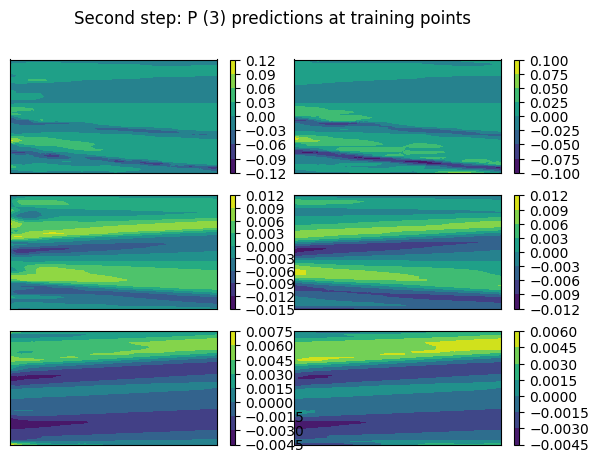

In [24]:
# Interpolant P^* at gh_tr points : P^*(hat S) vs. P(hat S)
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 2, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('Second step: P ({}) predictions at training points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(S[i*N_gh_tr:(i+1)*N_gh_tr,0], S[i*N_gh_tr:(i+1)*N_gh_tr,1], f_pred_train[i*N_gh_tr:(i+1)*N_gh_tr])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(S[i*N_gh_tr:(i+1)*N_gh_tr,0], S[i*N_gh_tr:(i+1)*N_gh_tr,1], f_train2[i*N_gh_tr:(i+1)*N_gh_tr])
        plt.colorbar(axsi1, ax = axs[i,1])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])

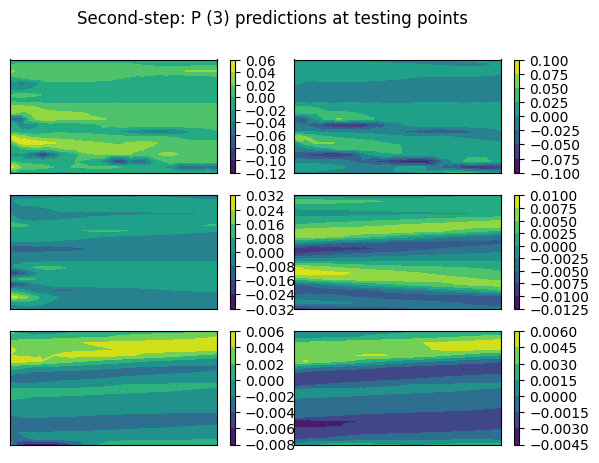

In [28]:
# Interpolant P^* at testing points : P^*(hat S) vs. P(hat S)
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 2, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('Second-step: P ({}) predictions at testing points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(X_te[i*N_te:(i+1)*N_te,0], X_te[i*N_te:(i+1)*N_te,1], f_pred_test[i*N_te:(i+1)*N_te])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(X_te[i*N_te:(i+1)*N_te,0], X_te[i*N_te:(i+1)*N_te,1], f_test2[i*N_te:(i+1)*N_te])
        plt.colorbar(axsi1, ax = axs[i,1])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])

In [27]:
# NMSEs: P at training points and testing points
print('Normalized MSEs between P and P^ for {} functions'.format(m))
for i in range(m):
    n_mse_train = mean_squared_error(f_pred_train[i*N_gh_tr:(i+1)*N_gh_tr], f_train2[i*N_gh_tr:(i+1)*N_gh_tr])/mean_squared_error(f_pred_train[i*N_gh_tr:(i+1)*N_gh_tr]*0, f_train2[i*N_gh_tr:(i+1)*N_gh_tr])
    n_mse_test = mean_squared_error(f_pred_test[i*N_te:(i+1)*N_te], f_test2[i*N_te:(i+1)*N_te])/mean_squared_error(f_pred_test[i*N_te:(i+1)*N_te]*0, f_test2[i*N_te:(i+1)*N_te])
    print('m = {} nmse_train = {}'.format(i,n_mse_train))
    print('m = {} nmse_test = {}'.format(i,n_mse_test))

Normalized MSEs between P and P^ for 3 functions
m = 0 nmse_train = 0.1839744114446458
m = 0 nmse_test = 0.2598964806683761
m = 1 nmse_train = 0.10902073046488034
m = 1 nmse_test = 0.8205313020602625
m = 2 nmse_train = 0.09997172257761923
m = 2 nmse_test = 0.22872767905832236


Plot the differences ! 